<a href="https://colab.research.google.com/github/ridwaanhall/aco-algorithm/blob/assgnmnt-2.1/notebook_99.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First of All

## Import Depedencies

In [7]:
pip install tabulate

In [8]:
import time
import math
import random
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import concurrent.futures

from PIL import Image
from itertools import chain
from tabulate import tabulate
from typing import Any, Callable, Dict, List, Set, Tuple, Union

## Initial Map Kecamatan

In [9]:
url = "https://raw.githubusercontent.com/ridwaanhall/aco-algorithm/refs/heads/assgnmnt-2/images/cj_sry.png"
image = Image.open(urllib.request.urlopen(url))
MAP_KECAMATAN = np.array(image)

# Kecamatan and Path Class FUnctions

In [10]:
class Kecamatan:
    """Represents a kecamatan with its name and coordinates."""

    def __init__(self, name: str, coordinates: Tuple[int, int]):
        if not isinstance(name, str):
            raise TypeError("Kecamatan name must be a string.")
        if (
            not isinstance(coordinates, tuple)
            or len(coordinates) != 2
            or not all(isinstance(coord, (int, float)) for coord in coordinates)
        ):
            raise TypeError("Coordinates must be a tuple of two numbers.")
        self.name = name
        self.coordinates = coordinates

    def __repr__(self) -> str:
        return f"Kecamatan(name='{self.name}', coordinates={self.coordinates})"

    def __eq__(self, other: object) -> bool:
        if not isinstance(other, Kecamatan):
            return False
        return self.name == other.name and self.coordinates == other.coordinates

    def __hash__(self) -> int:
        return hash((self.name, self.coordinates))


class Path:
    """Represents a path as a list of Kecamatan objects."""

    def __init__(self, kecamatan: List[Kecamatan]):
        if not isinstance(kecamatan, list):
            raise TypeError("Kecamatan must be a list.")
        if not all(isinstance(kec, Kecamatan) for kec in kecamatan):
            raise TypeError("All elements in kecamatan list must be Kecamatan objects.")

        self.kecamatan = kecamatan
        self._distances = self._calculate_distances()

    def __repr__(self) -> str:
        return f"Path(kecamatan={[kec.name for kec in self.kecamatan]})"

    def get_coordinates(self) -> List[Tuple[int, int]]:
        """Returns a list of (x, y) coordinates from the kecamatan in the path."""
        return [kec.coordinates for kec in self.kecamatan]

    def is_valid(self) -> bool:
        """Checks if the path contains all unique kecamatan."""
        return len(self.kecamatan) == len(set(self.kecamatan))

    def to_dict(self) -> Dict[str, Tuple[int, int]]:
        """Converts the Path to a dictionary of kecamatan names and coordinates."""
        return {kec.name: kec.coordinates for kec in self.kecamatan}

    def get_names(self) -> List[str]:
        """Return a list of kecamatan names in the path."""
        return [kec.name for kec in self.kecamatan]

    def to_list_of_tuples(self) -> List[Tuple[str, Tuple[int, int]]]:
        """Returns the path as a list of tuples of (name, coordinates)."""
        return [(kec.name, kec.coordinates) for kec in self.kecamatan]

    def _calculate_distances(self) -> List[float]:
        """Calculates the distances between consecutive kecamatan in the path."""
        distances = []
        for i in range(len(self.kecamatan) - 1):
            distances.append(distance(self.kecamatan[i], self.kecamatan[i + 1]))
        distances.append(distance(self.kecamatan[-1], self.kecamatan[0]))
        return distances

    def get_route_table(self) -> str:
        """Generates a table summarizing the kecamatan route with distances."""
        headers = ["Number", "Kecamatan Name", "Distance (from previous kecamatan)"]
        table_data = []
        for i, kec in enumerate(self.kecamatan):
            distance_val = self._distances[i]
            table_data.append([i + 1, kec.name, f"{distance_val:.2f}"])
        return tabulate(table_data, headers=headers, tablefmt="grid")

# Visualization Functions

In [11]:
def show_kecamatan(
    path: Union[Path, List[Kecamatan], Dict[str, Tuple[int, int]]], w: int = 12, h: int = 8
) -> None:
    """Plots kecamatans on the US map."""

    if isinstance(path, Path):
        path_coords = path.get_coordinates()
    elif isinstance(path, list) and all(isinstance(kecamatan, Kecamatan) for kecamatan in path):
        path_coords = [kecamatan.coordinates for kecamatan in path]
    elif isinstance(path, dict):
        path_coords = list(path.values())
    elif isinstance(path, list) and isinstance(path[0], tuple):
        path_coords = [item[1] for item in path]
    else:
        raise ValueError("Invalid path format.")

    plt.imshow(MAP_KECAMATAN)
    for x0, y0 in path_coords:
        plt.plot(x0, y0, "y*", markersize=15)
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])
    plt.show()


def show_path(
    path: Union[Path, List[Kecamatan], Dict[str, Tuple[int, int]]],
    starting_kecamatan: Union[Kecamatan, Tuple[int, int]] = None,
    w: int = 12,
    h: int = 8,
) -> None:
    """Plots a path on the US map."""
    if isinstance(path, Path):
        path_coords = path.get_coordinates()
    elif isinstance(path, list) and all(isinstance(kecamatan, Kecamatan) for kecamatan in path):
        path_coords = [kecamatan.coordinates for kecamatan in path]
    elif isinstance(path, dict):
        path_coords = list(path.values())
    elif isinstance(path, list) and isinstance(path[0], tuple):
        path_coords = [item[1] for item in path]
    else:
        raise ValueError("Invalid path format.")

    if isinstance(starting_kecamatan, Kecamatan):
        starting_coords = starting_kecamatan.coordinates
    elif isinstance(starting_kecamatan, tuple):
        starting_coords = starting_kecamatan
    elif starting_kecamatan is None:
        starting_coords = path_coords[0]
    else:
        raise ValueError("Invalid starting_kecamatan format.")

    x, y = zip(*path_coords)
    plt.imshow(MAP_KECAMATAN)
    plt.plot(x + x[:1], y + y[:1])
    plt.plot(
        starting_coords[0], starting_coords[1], "y*", markersize=15
    )  # start from origin with star
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])
    plt.show()


def polyfit_plot(x: List[float], y: List[float], deg: int, **kwargs: Any) -> None:
    """Plots a polynomial fit of the given x and y data."""
    coefficients = np.polyfit(x, y, deg, **kwargs)
    poly = np.poly1d(coefficients)
    new_x = np.linspace(x[0], x[-1])
    new_y = poly(new_x)
    plt.plot(x, y, "o", new_x, new_y)
    plt.xlim([x[0] - 1, x[-1] + 1])

    terms = []
    for p, c in enumerate(reversed(coefficients)):
        term = str(round(c, 1))
        if p == 1:
            term += "x"
        if p >= 2:
            term += "x^" + str(p)
        terms.append(term)
    plt.title(" + ".join(reversed(terms)))
    plt.show()


def distance(
    kecamatan1: Union[Kecamatan, Tuple[str, Tuple[int, int]]],
    kecamatan2: Union[Kecamatan, Tuple[str, Tuple[int, int]]],
) -> float:
    """Calculates the Euclidean distance between two kecamatans."""
    if isinstance(kecamatan1, Kecamatan) and isinstance(kecamatan2, Kecamatan):
        xy1 = kecamatan1.coordinates
        xy2 = kecamatan2.coordinates
    elif isinstance(kecamatan1, tuple) and isinstance(kecamatan2, tuple):
        xy1 = kecamatan1[1]
        xy2 = kecamatan2[1]
    else:
        raise ValueError("Invalid kecamatan format.")
    return math.sqrt((xy1[0] - xy2[0]) ** 2 + (xy1[1] - xy2[1]) ** 2)


def path_distance(path: Union[Path, List[Kecamatan], Dict[str, Tuple[int, int]]]) -> int:
    """Calculates the total distance of a path."""
    if isinstance(path, Path):
        kecamatans = path.kecamatan
    elif isinstance(path, list) and all(isinstance(kecamatan, Kecamatan) for kecamatan in path):
        kecamatans = path
    elif isinstance(path, dict):
        kecamatans = [Kecamatan(name, coords) for name, coords in path.items()]
    elif isinstance(path, list) and isinstance(path[0], tuple):
        kecamatans = [Kecamatan(name, coords) for name, coords in path]
    else:
        raise ValueError("Invalid path format.")

    total_distance = 0
    for i in range(len(kecamatans) - 1):
        total_distance += distance(kecamatans[i], kecamatans[i + 1])
    total_distance += distance(
        kecamatans[-1], kecamatans[0]
    )  # include the distance of return journey
    return int(total_distance)

# Ant COlony Solver

In [12]:
class AntColonySolver:
    """Solves the Traveling Salesperson Problem using Ant Colony Optimization."""

    def __init__(
        self,
        cost_fn: Callable[[Any, Any], Union[float, int]],
        time_limit: int = 0,
        min_time: int = 0,
        timeout: int = 0,
        stop_factor: float = 2,
        min_round_trips: int = 10,
        max_round_trips: int = 0,
        min_ants: int = 0,
        max_ants: int = 0,
        ant_count: int = 64,
        ant_speed: int = 1,
        distance_power: float = 1,
        pheromone_power: float = 1.25,
        decay_power: float = 0,
        reward_power: float = 0,
        best_path_smell: float = 2,
        start_smell: float = 0,
        verbose: bool = False,
    ):
        """
        Initializes the Ant Colony Solver.

        Args:
            cost_fn (Callable): A function that calculates the cost between two nodes.
            time_limit (int): Run for a fixed amount of time.
            min_time (int): Minimum runtime.
            timeout (int): Maximum time in seconds to run for.
            stop_factor (float): How many times to redouble effort after new new best path.
            min_round_trips (int): Minimum number of round trips before stopping.
            max_round_trips (int): Maximum number of round trips before stopping.
            min_ants (int): Total number of ants to use.
            max_ants (int): Total number of ants to use.
            ant_count (int): The number of ants to use.
            ant_speed (int): How many steps do ants travel per epoch.
            distance_power (float): Power to which distance affects pheromones.
            pheromone_power (float): Power to which differences in pheromones are noticed.
            decay_power (float): How fast do pheromones decay.
            reward_power (float): Relative pheromone reward based on best_path_length/path_length.
            best_path_smell (float): Queen multiplier for pheromones upon finding a new best path.
            start_smell (float): Amount of starting pheromones.
            verbose (bool): Whether to print verbose output.
        """
        if not callable(cost_fn):
            raise TypeError("cost_fn must be a callable function.")
        if not all(
            isinstance(arg, (int, float))
            for arg in [
                time_limit,
                min_time,
                timeout,
                stop_factor,
                min_round_trips,
                max_round_trips,
                min_ants,
                max_ants,
                ant_count,
                ant_speed,
                distance_power,
                pheromone_power,
                decay_power,
                reward_power,
                best_path_smell,
                start_smell,
            ]
        ):
            raise TypeError("All numeric arguments must be int or float.")
        if not isinstance(verbose, bool):
            raise TypeError("verbose must be a boolean.")

        self.cost_fn = cost_fn
        self.time_limit = int(time_limit)
        self.min_time = int(min_time)
        self.timeout = int(timeout)
        self.stop_factor = float(stop_factor)
        self.min_round_trips = int(min_round_trips)
        self.max_round_trips = int(max_round_trips)
        self.min_ants = int(min_ants)
        self.max_ants = int(max_ants)

        self.ant_count = int(ant_count)
        self.ant_speed = int(ant_speed)

        self.distance_power = float(distance_power)
        self.pheromone_power = float(pheromone_power)
        self.decay_power = float(decay_power)
        self.reward_power = float(reward_power)
        self.best_path_smell = float(best_path_smell)
        self.start_smell = float(start_smell or 10**self.distance_power)

        self.verbose = bool(verbose)
        self._initalized = False

        if self.min_round_trips and self.max_round_trips:
            self.min_round_trips = min(self.min_round_trips, self.max_round_trips)
        if self.min_ants and self.max_ants:
            self.min_ants = min(self.min_ants, self.max_ants)

    def _solve_initialize(
        self,
        problem_path: List[Kecamatan],
    ) -> None:
        """Initializes the solver with problem-specific data.

        Args:
            problem_path (List[Kecamatan]): The list of kecamatans to be visited.
        """
        if not isinstance(problem_path, list) or not all(
            isinstance(kecamatan, Kecamatan) for kecamatan in problem_path
        ):
            raise ValueError("problem_path must be a list of Kecamatan objects.")

        ### Cache of distances between nodes
        self.distances = {
            source: {dest: self.cost_fn(source, dest) for dest in problem_path}
            for source in problem_path
        }

        ### Cache of distance costs between nodes - division in a tight loop is expensive
        self.distance_cost = {
            source: {
                dest: 1 / (1 + self.distances[source][dest]) ** self.distance_power
                for dest in problem_path
            }
            for source in problem_path
        }

        ### This stores the pheromone trail that slowly builds up
        self.pheromones = {
            source: {
                # Encourage the ants to start exploring in all directions and furthest nodes
                dest: self.start_smell
                for dest in problem_path
            }
            for source in problem_path
        }

        ### Sanitise input parameters
        if self.ant_count <= 0:
            self.ant_count = len(problem_path)
        if self.ant_speed <= 0:
            self.ant_speed = (
                np.median(list(chain(*[d.values() for d in self.distances.values()])))
                // 5
            )
        self.ant_speed = int(max(1, self.ant_speed))

        ### Heuristic Exports
        self.ants_used = 0
        self.epochs_used = 0
        self.round_trips = 0
        self._initalized = True

    def solve(
        self,
        problem_path: List[Kecamatan],
        restart: bool = False,
    ) -> Path:
        """Solves the TSP problem using ACO.

        Args:
            problem_path (List[Kecamatan]): The list of kecamatans to be visited.
            restart (bool): Whether to restart the solver.

        Returns:
             Path: The best path found by the solver.
        """
        if not isinstance(problem_path, list) or not all(
            isinstance(kecamatan, Kecamatan) for kecamatan in problem_path
        ):
            raise ValueError("problem_path must be a list of Kecamatan objects.")
        if not isinstance(restart, bool):
            raise TypeError("restart must be a boolean.")

        if restart or not self._initalized:
            self._solve_initialize(problem_path)

        ### Here come the ants!
        ants = {
            "distance": np.zeros((self.ant_count,)).astype("int32"),
            "path": [[problem_path[0]] for _ in range(self.ant_count)],
            "remaining": [set(problem_path[1:]) for _ in range(self.ant_count)],
            "path_cost": np.zeros((self.ant_count,)).astype("int32"),
            "round_trips": np.zeros((self.ant_count,)).astype("int32"),
        }

        best_path = None
        best_path_cost = np.inf
        best_epochs = []
        epoch = 0
        time_start = time.perf_counter()
        while True:
            epoch += 1

            ### Vectorized walking of ants
            # Small optimization here, testing against `> self.ant_speed` rather than `> 0`
            #       avoids computing ants_arriving in the main part of this tight loop
            ants_travelling = ants["distance"] > self.ant_speed
            ants["distance"][ants_travelling] -= self.ant_speed
            if all(ants_travelling):
                continue  # skip termination checks until the next ant arrives

            ### Vectorized checking of ants arriving
            ants_arriving = np.invert(ants_travelling)
            ants_arriving_index = np.where(ants_arriving)[0]
            for i in ants_arriving_index:

                ### ant has arrived at next_node
                this_node = ants["path"][i][-1]
                next_node = self._next_node(ants, i)
                ants["distance"][i] = self.distances[this_node][next_node]
                ants["remaining"][i] = ants["remaining"][i] - {this_node}
                ants["path_cost"][i] = ants["path_cost"][i] + ants["distance"][i]
                ants["path"][i].append(next_node)

                ### ant has returned home to the colony
                if (
                    not ants["remaining"][i]
                    and ants["path"][i][0] == ants["path"][i][-1]
                ):
                    self.ants_used += 1
                    self.round_trips = max(self.round_trips, ants["round_trips"][i] + 1)

                    ### We have found a new best path - inform the Queen
                    was_best_path = False
                    if ants["path_cost"][i] < best_path_cost:
                        was_best_path = True
                        best_path_cost = ants["path_cost"][i]
                        best_path = ants["path"][i]
                        best_epochs += [epoch]
                        if self.verbose:
                            print(
                                {
                                    "path_cost": int(ants["path_cost"][i]),
                                    "ants_used": self.ants_used,
                                    "epoch": epoch,
                                    "round_trips": ants["round_trips"][i] + 1,
                                    "clock": int(time.perf_counter() - time_start),
                                }
                            )

                    ### leave pheromone trail
                    # doing this only after ants arrive home improves initial exploration
                    #  * self.round_trips has the effect of decaying old pheromone trails
                    # ** self.reward_power = -3 has the effect of encouraging ants to explore longer routes
                    #                           in combination with doubling pheromone for best_path
                    reward = 1
                    if self.reward_power:
                        reward *= (
                            best_path_cost / ants["path_cost"][i]
                        ) ** self.reward_power
                    if self.decay_power:
                        reward *= self.round_trips**self.decay_power
                    for path_index in range(len(ants["path"][i]) - 1):
                        this_node = ants["path"][i][path_index]
                        next_node = ants["path"][i][path_index + 1]
                        self.pheromones[this_node][next_node] += reward
                        self.pheromones[next_node][this_node] += reward
                        if was_best_path:
                            # Queen orders to double the number of ants following this new best path
                            self.pheromones[this_node][
                                next_node
                            ] *= self.best_path_smell
                            self.pheromones[next_node][
                                this_node
                            ] *= self.best_path_smell

                    ### reset ant
                    ants["distance"][i] = 0
                    ants["path"][i] = [problem_path[0]]
                    ants["remaining"][i] = set(problem_path[1:])
                    ants["path_cost"][i] = 0
                    ants["round_trips"][i] += 1

            ### Do we terminate?

            # Always wait for at least 1 solutions (note: 2+ solutions are not guaranteed)
            if not len(best_epochs):
                continue

            # Timer takes priority over other constraints
            if self.time_limit or self.min_time or self.timeout:
                clock = time.perf_counter() - time_start
                if self.time_limit:
                    if clock > self.time_limit:
                        break
                    else:
                        continue
                if self.min_time and clock < self.min_time:
                    continue
                if self.timeout and clock > self.timeout:
                    break

            # First epoch only has start smell - question: how many epochs are required for a reasonable result?
            if self.min_round_trips and self.round_trips < self.min_round_trips:
                continue
            if self.max_round_trips and self.round_trips >= self.max_round_trips:
                break

            # This factor is most closely tied to computational power
            if self.min_ants and self.ants_used < self.min_ants:
                continue
            if self.max_ants and self.ants_used >= self.max_ants:
                break

            # Lets keep redoubling our efforts until we can't find anything more
            if self.stop_factor and epoch > (best_epochs[-1] * self.stop_factor):
                break

            # Nothing else is stopping us: Queen orders the ants to continue!
            if True:
                continue

        ### We have (hopefully) found a near-optimal path, report back to the Queen
        self.epochs_used = epoch
        self.round_trips = np.max(ants["round_trips"])
        return Path(best_path)

    def _next_node(self, ants: Dict[str, Any], index: int) -> Kecamatan:
        """Determines the next node an ant will visit.

        Args:
            ants (Dict): The dictionary containing ant information.
            index (int): The index of the ant in the ant dictionary.

        Returns:
            Kecamatan: The next kecamatan the ant will visit.
        """
        this_node = ants["path"][index][-1]

        weights = []
        weights_sum = 0
        if not ants["remaining"][index]:
            return ants["path"][index][0]  # return home
        for next_node in ants["remaining"][index]:
            if next_node == this_node:
                continue
            reward = (
                self.pheromones[this_node][next_node] ** self.pheromone_power
                * self.distance_cost[this_node][next_node]  # Prefer shorter paths
            )
            weights.append((reward, next_node))
            weights_sum += reward

        # Pick a random path in proportion to the weight of the pheromone
        rand = random.random() * weights_sum
        for weight, next_node in weights:
            if rand > weight:
                rand -= weight
            else:
                break
        return next_node


def AntColonyRunner(
    kecamatans: List[Kecamatan],
    verbose: bool = False,
    plot: bool = False,
    label: Dict = {},
    algorithm: Callable = AntColonySolver,
    **kwargs: Any,
) -> Path:
    """Runs the Ant Colony Optimization algorithm.

    Args:
        kecamatans (List[Kecamatan]): The list of kecamatans to be visited.
        verbose (bool): Whether to print verbose output.
        plot (bool): Whether to plot the path.
        label (Dict): Additional labels for the output.
        algorithm (Callable): The algorithm to use.
        **kwargs: Additional keyword arguments for the algorithm.

    Returns:
        Path: The best path found by the algorithm.
    """
    if not isinstance(kecamatans, list) or not all(
        isinstance(kecamatan, Kecamatan) for kecamatan in kecamatans
    ):
        raise ValueError("kecamatans must be a list of Kecamatan objects.")
    if not isinstance(verbose, bool):
        raise TypeError("verbose must be a boolean.")
    if not isinstance(plot, bool):
        raise TypeError("plot must be a boolean.")
    if not isinstance(label, dict):
        raise TypeError("label must be a dictionary.")
    if not callable(algorithm):
        raise TypeError("algorithm must be callable")

    solver = algorithm(cost_fn=distance, verbose=verbose, **kwargs)
    start_time = time.perf_counter()
    result = solver.solve(kecamatans)
    stop_time = time.perf_counter()
    if label:
        kwargs = {**label, **kwargs}

    for key in ["verbose", "plot", "animate", "label", "min_time", "max_time"]:
        if key in kwargs:
            del kwargs[key]
    print(
        "N={:<3d} | {:5.0f} -> {:4.0f} | {:4.0f}s | ants: {:5d} | trips: {:4d} | ".format(
            len(kecamatans),
            path_distance(kecamatans),
            path_distance(result),
            (stop_time - start_time),
            solver.ants_used,
            solver.round_trips,
        )
        + " ".join([f"{k}={v}" for k, v in kwargs.items()])
    )
    if plot:
        show_path(result)
    return result

# Setting Up

## Kecamatan Data

In [13]:
kecamatan_data = {
    "Mlati": (318, 539),
    "Sleman": (351, 436),
    "Ngaglik": (489, 511),
    "Tempel": (310, 345),
    "Sayegan": (272, 511),
    "Godean": (226, 615),
    "Ngemplak": (589, 454),
    "Cangkringan": (618, 362),
    "Pakem": (531, 381),
    "Kaliurang": (543, 226),
    "Manisrenggo": (698, 451),
    "Kemalang": (764, 378),
    "Karangnongko": (842, 396),
    "Kebonarum": (865, 454),
    "Klaten": (951, 471),
    "Karanganom": (1007, 333),
    "Jatinom": (947, 304),
    "Polanharjo": (1089, 252),
    "Tulung": (998, 203),
    "Banyudono": (1132, 101),
    "Teras": (1089, 74),
    "Mojosongo": (1017, 77),
    "Boyolali": (946, 63),
    "Musuk": (852, 75),
    "Cepogo": (754, 20),
    "Sawangan": (311, 74),
    "Muntilan": (212, 177),
    "Srumbung": (320, 219),
    "Salam": (284, 284),
    "Turi": (429, 344),
    "Kalibawang": (165, 400),
    "Kalasan": (636, 623),
    "Moyudan": (141, 631),
}

## Number of Kecamatan

In [14]:
kecamatans = [Kecamatan(name, coords) for name, coords in sorted(kecamatan_data.items())]
print(f"Number of kecamatans: {len(kecamatans)}")

Number of kecamatans: 33


# Show Visualizations

## Show Kecamatan

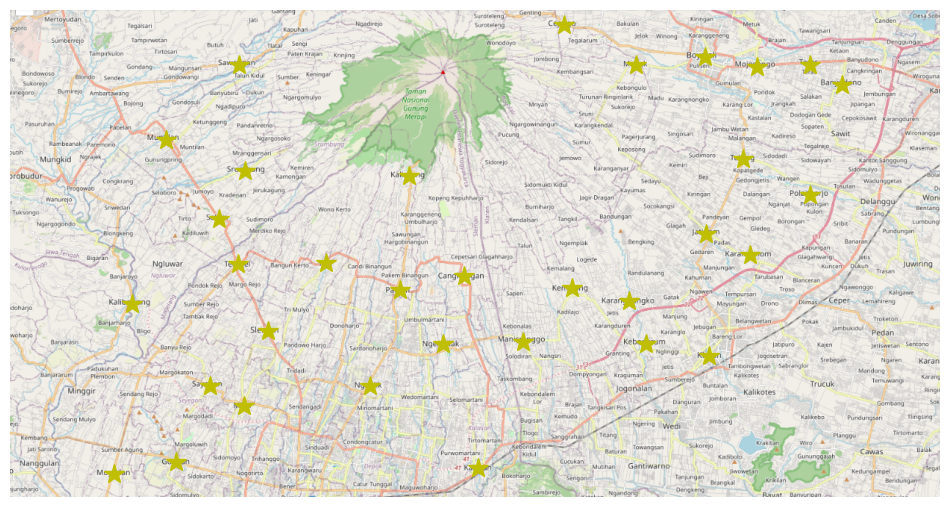

In [15]:
show_kecamatan(kecamatans)

## Show Path

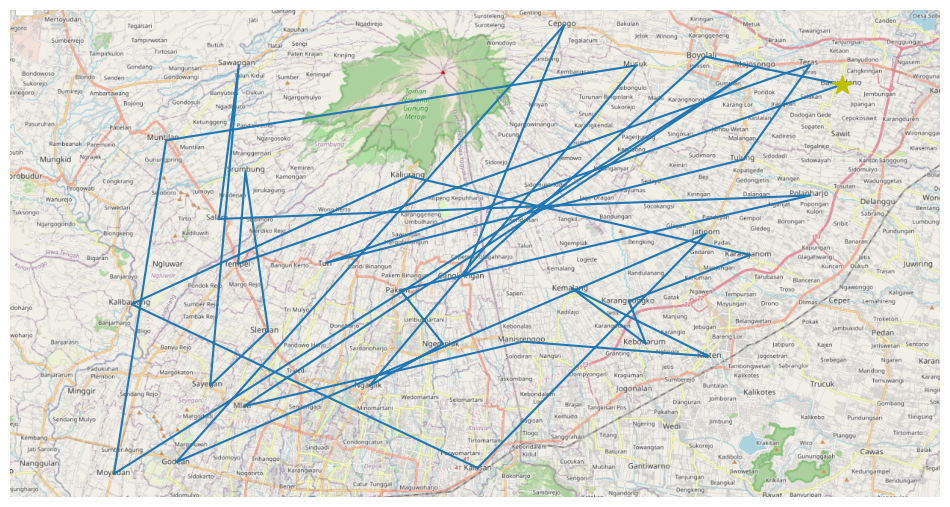

In [16]:
show_path(kecamatans)

# Run Algorithm

## Normally

{'path_cost': 9502, 'ants_used': 1, 'epoch': 8684, 'round_trips': 1, 'clock': 0}
{'path_cost': 9113, 'ants_used': 2, 'epoch': 8926, 'round_trips': 1, 'clock': 0}
{'path_cost': 8980, 'ants_used': 51, 'epoch': 17827, 'round_trips': 2, 'clock': 0}
{'path_cost': 8700, 'ants_used': 53, 'epoch': 17895, 'round_trips': 2, 'clock': 0}
{'path_cost': 7920, 'ants_used': 54, 'epoch': 18112, 'round_trips': 2, 'clock': 0}
{'path_cost': 7879, 'ants_used': 101, 'epoch': 25174, 'round_trips': 3, 'clock': 0}
{'path_cost': 7466, 'ants_used': 104, 'epoch': 26040, 'round_trips': 3, 'clock': 0}
{'path_cost': 7242, 'ants_used': 112, 'epoch': 26813, 'round_trips': 3, 'clock': 0}
{'path_cost': 7043, 'ants_used': 117, 'epoch': 27373, 'round_trips': 3, 'clock': 0}
{'path_cost': 6976, 'ants_used': 122, 'epoch': 27510, 'round_trips': 3, 'clock': 0}
{'path_cost': 6524, 'ants_used': 153, 'epoch': 32285, 'round_trips': 4, 'clock': 0}
{'path_cost': 5790, 'ants_used': 154, 'epoch': 32489, 'round_trips': 4, 'clock': 0}
{

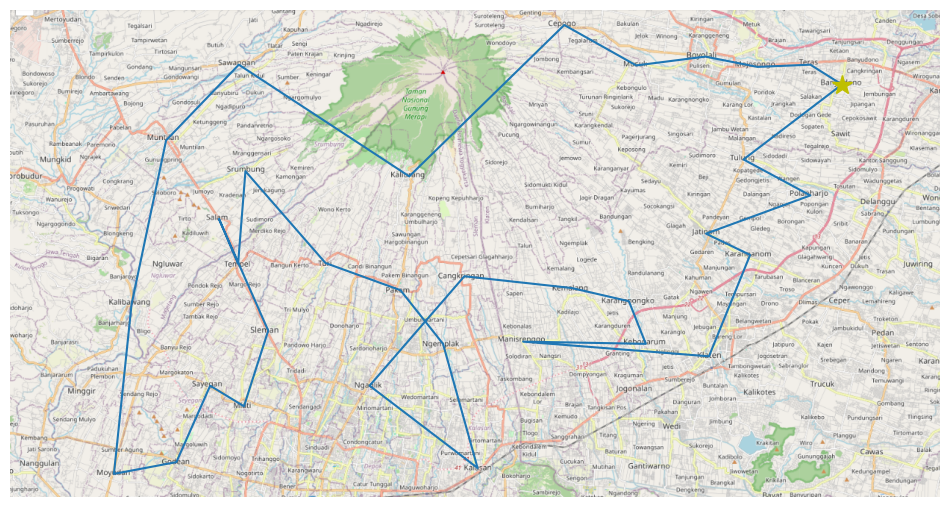

In [17]:
results = AntColonyRunner(
    kecamatans,
    distance_power=1,
    verbose=True,
    plot=True,
    ant_count=50,
    ant_speed=1,
    min_round_trips=50,
)

In [18]:
print("\nRoute Table (results):")
print(results.get_route_table())


Route Table (results):
+----------+------------------+--------------------------------------+
|   Number | Kecamatan Name   |   Distance (from previous kecamatan) |
+==========+==================+======================================+
|        1 | Banyudono        |                                50.77 |
+----------+------------------+--------------------------------------+
|        2 | Teras            |                                72.06 |
+----------+------------------+--------------------------------------+
|        3 | Mojosongo        |                                72.37 |
+----------+------------------+--------------------------------------+
|        4 | Boyolali         |                                94.76 |
+----------+------------------+--------------------------------------+
|        5 | Musuk            |                               112.38 |
+----------+------------------+--------------------------------------+
|        6 | Cepogo           |                      

# Hyperparameter Optimizations

## Manual Hyperparameter

{'path_cost': 8814, 'ants_used': 1, 'epoch': 7864, 'round_trips': 1, 'clock': 0}
{'path_cost': 8707, 'ants_used': 34, 'epoch': 16730, 'round_trips': 2, 'clock': 0}
{'path_cost': 7605, 'ants_used': 35, 'epoch': 17154, 'round_trips': 2, 'clock': 0}
{'path_cost': 7173, 'ants_used': 69, 'epoch': 25807, 'round_trips': 3, 'clock': 0}
{'path_cost': 6588, 'ants_used': 83, 'epoch': 27836, 'round_trips': 3, 'clock': 0}
{'path_cost': 6279, 'ants_used': 105, 'epoch': 33155, 'round_trips': 4, 'clock': 0}
{'path_cost': 5786, 'ants_used': 176, 'epoch': 47644, 'round_trips': 6, 'clock': 0}
{'path_cost': 5673, 'ants_used': 240, 'epoch': 60262, 'round_trips': 8, 'clock': 0}
{'path_cost': 5121, 'ants_used': 276, 'epoch': 67142, 'round_trips': 9, 'clock': 0}
{'path_cost': 5082, 'ants_used': 294, 'epoch': 69411, 'round_trips': 9, 'clock': 0}
{'path_cost': 5079, 'ants_used': 296, 'epoch': 70067, 'round_trips': 9, 'clock': 0}
{'path_cost': 4973, 'ants_used': 333, 'epoch': 76336, 'round_trips': 11, 'clock': 0

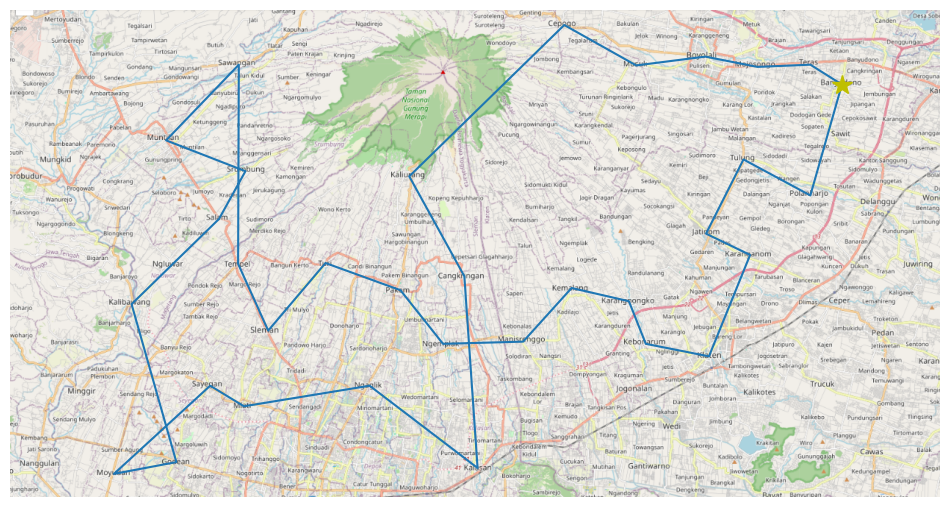

In [19]:
results_2 = AntColonyRunner(
    kecamatans,
    distance_power=1,
    verbose=True,
    plot=True,
    ant_count=len(kecamatans),
    ant_speed=1,
    min_round_trips=50,
    reward_power=-0.5,
    stop_factor=5,
    min_ants=len(kecamatans),
)

In [20]:
print("\nRoute Table (results_2):")
print(results_2.get_route_table())


Route Table (results_2):
+----------+------------------+--------------------------------------+
|   Number | Kecamatan Name   |   Distance (from previous kecamatan) |
+==========+==================+======================================+
|        1 | Banyudono        |                                50.77 |
+----------+------------------+--------------------------------------+
|        2 | Teras            |                                72.06 |
+----------+------------------+--------------------------------------+
|        3 | Mojosongo        |                                72.37 |
+----------+------------------+--------------------------------------+
|        4 | Boyolali         |                                94.76 |
+----------+------------------+--------------------------------------+
|        5 | Musuk            |                               112.38 |
+----------+------------------+--------------------------------------+
|        6 | Cepogo           |                    

## Loop Hyperparameter

In [21]:
def run_ant_colony(
    kecamatans,
    hyperparameters: Dict[str, Any]
):
    """
    Runs the Ant Colony Optimization algorithm with configurable hyperparameters.

    Args:
        kecamatans: The list of kecamatans (likely City objects) to visit.
        hyperparameters: A dictionary containing the hyperparameters for the algorithm.

    Returns:
        The results of the Ant Colony Optimization (a Path object).
    """

    # Default values, can be overridden by hyperparameters
    default_hyperparameters = {
        "distance_power": 1,
        "verbose": False,
        "plot": False,
        "ant_count": len(kecamatans),
        "ant_speed": 1,
        "min_round_trips": 50,
        "reward_power": -0.5,
        "stop_factor": 5,
        "min_ants": len(kecamatans),
    }

    # Merge default hyperparameters with provided hyperparameters,
    # giving priority to the provided ones
    merged_hyperparameters = {**default_hyperparameters, **hyperparameters}

    results = AntColonyRunner(
        kecamatans,
        distance_power=merged_hyperparameters["distance_power"],
        verbose=merged_hyperparameters["verbose"],
        plot=merged_hyperparameters["plot"],
        ant_count=merged_hyperparameters["ant_count"],
        ant_speed=merged_hyperparameters["ant_speed"],
        min_round_trips=merged_hyperparameters["min_round_trips"],
        reward_power=merged_hyperparameters["reward_power"],
        stop_factor=merged_hyperparameters["stop_factor"],
        min_ants=merged_hyperparameters["min_ants"],
    )
    return results


def hyperparameter_optimization(
    kecamatans,
    hyperparameter_ranges: Dict[str, List[Any]],
    num_trials: int = 10,
    num_combinations: int = 10 # Added new num_combinations parameter
) -> Tuple[Dict[str, Any], int]:
    """
    Loops through random hyperparameter combinations, finds the best one, and returns it along with the best distance.

    Args:
        kecamatans: The list of kecamatans (likely City objects) to visit.
        hyperparameter_ranges: Dictionary defining hyperparameter name and their possible values
        num_trials: number of trials per parameter set
        num_combinations: number of random parameter sets

    Returns:
        Best hyperparameter combination and the best distance found
    """
    best_distance = float('inf')
    best_hyperparameters = {}
    keys = list(hyperparameter_ranges.keys())

    print("Starting hyperparameter optimization with random search...")

    for i in range(num_combinations):
        current_combination = {}
        # Generate Random hyperparameter combination
        for key in keys:
            current_combination[key] = random.choice(hyperparameter_ranges[key])

        print(f"Testing combination {i + 1}/{num_combinations}: {current_combination}")

        # Parallelized trial runs with concurrent.futures
        trial_distances = []
        trial_times = []
        with concurrent.futures.ThreadPoolExecutor() as executor:
          futures = [executor.submit(run_ant_colony, kecamatans, current_combination) for _ in range(num_trials)]
          for trial, future in enumerate(futures):
            start_time = time.time()
            results = future.result()
            end_time = time.time()
            trial_distance = path_distance(results)
            trial_distances.append(trial_distance)
            trial_times.append(end_time - start_time)
            print(f"Trial {trial + 1} execution time: {trial_times[trial]}, distance: {trial_distances[trial]}")

        avg_distance = sum(trial_distances) / num_trials
        print(f"Hyperparameters: {current_combination}, Average Distance: {avg_distance}")

        if avg_distance < best_distance:
            best_distance = avg_distance
            best_hyperparameters = current_combination
            print(f"New best hyperparameters found: {best_hyperparameters} with distance of {best_distance}")

    print("Hyperparameter optimization finished.")
    return best_hyperparameters, int(best_distance)


def run_with_best_hyperparameters(
    kecamatans,
    best_hyperparameters: Dict[str, Any]
) -> int:
    """
    Runs the Ant Colony Optimization algorithm with the best hyperparameters and returns the best distance.

    Args:
        kecamatans: The list of kecamatans (likely City objects) to visit.
        best_hyperparameters: The dictionary of best hyperparameters found.

    Returns:
        The best distance from the best hyperparameters
    """
    print(f"Running with best hyperparameters: {best_hyperparameters}")
    results = run_ant_colony(kecamatans, best_hyperparameters)
    return path_distance(results)

### Hyperparameter Params Combination

In [22]:
hyperparameter_ranges = {
    "distance_power": [1, 2],
    "ant_count": [len(kecamatans), len(kecamatans) // 2],
    "min_round_trips": [50, 100],
    "reward_power": [-0.5, -1],
    "stop_factor": [2, 5],
}

In [24]:
best_hyperparameters, best_distance_found = hyperparameter_optimization(
    kecamatans,
    hyperparameter_ranges,
    num_trials=2,
    num_combinations=5,
)

Starting hyperparameter optimization with random search...
Testing combination 1/5: {'distance_power': 1, 'ant_count': 33, 'min_round_trips': 100, 'reward_power': -0.5, 'stop_factor': 5}
N=33  | 14213 -> 4440 |   40s | ants:  6530 | trips:  200 | distance_power=1 ant_count=33 ant_speed=1 min_round_trips=100 reward_power=-0.5 stop_factor=5 min_ants=33
N=33  | 14213 -> 4498 |  256s | ants: 59394 | trips: 1807 | distance_power=1 ant_count=33 ant_speed=1 min_round_trips=100 reward_power=-0.5 stop_factor=5 min_ants=33
Trial 1 execution time: 255.4191734790802, distance: 4498
Trial 2 execution time: 5.0067901611328125e-06, distance: 4440
Hyperparameters: {'distance_power': 1, 'ant_count': 33, 'min_round_trips': 100, 'reward_power': -0.5, 'stop_factor': 5}, Average Distance: 4469.0
New best hyperparameters found: {'distance_power': 1, 'ant_count': 33, 'min_round_trips': 100, 'reward_power': -0.5, 'stop_factor': 5} with distance of 4469.0
Testing combination 2/5: {'distance_power': 1, 'ant_cou

In [25]:
import json

print("\nBest Hyperparameters Found:")
print(json.dumps(best_hyperparameters, indent=4))
print(f"\nBest Distance Found (from optimization): {best_distance_found}")


Best Hyperparameters Found:
{
    "distance_power": 2,
    "ant_count": 16,
    "min_round_trips": 50,
    "reward_power": -0.5,
    "stop_factor": 2
}

Best Distance Found (from optimization): 4073


### Best Hyperparameters

In [28]:
best_distance = run_with_best_hyperparameters(kecamatans, best_hyperparameters)
print(f"\nBest Distance (after running with best parameters): {best_distance}")

Running with best hyperparameters: {'distance_power': 2, 'ant_count': 16, 'min_round_trips': 50, 'reward_power': -0.5, 'stop_factor': 2}
N=33  | 14213 -> 4001 |   11s | ants:  4096 | trips:  261 | distance_power=2 ant_count=16 ant_speed=1 min_round_trips=50 reward_power=-0.5 stop_factor=2 min_ants=33

Best Distance (after running with best parameters): 4001


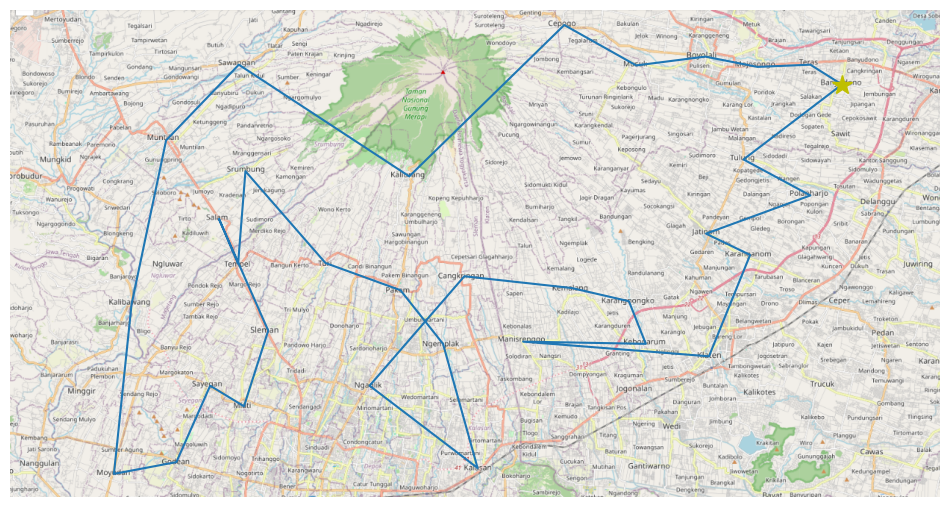

In [33]:
show_path(results)